# 🧠 D&D Monster Analytics: Fase 4 - Ottimizzazione e Feature Selection

**Obiettivo:** Verificare se è possibile semplificare il modello riducendo il numero di variabili senza sacrificare l'accuratezza.

### 🧪 Esperimento "Less is More"
Confronteremo le performance di due versioni del modello Random Forest:
1.  **Full Model:** Addestrato su tutte le feature disponibili (73 colonne).
2.  **Lean Model:** Addestrato solo sulle Top 20 feature più influenti.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Configurazione Plot
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
print("✅ Librerie caricate.")

✅ Librerie caricate.


## 1. Caricamento e Baseline (Modello Completo)
Ripetiamo brevemente il training del modello completo per avere i dati di confronto.

In [4]:
# Caricamento
df = pd.read_csv("./data/monsters_final.csv")
if 'name' in df.columns: df = df.drop(columns=['name'])
print(f"✅ Dataset: {df.shape}")

# Split
X = df.drop(columns=['cr'])
y = df['cr']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training Full Model
rf_full = RandomForestRegressor(n_estimators=100, random_state=42)
rf_full.fit(X_train, y_train)

# Valutazione Full
y_pred_full = rf_full.predict(X_test)
r2_full = r2_score(y_test, y_pred_full)
mae_full = mean_absolute_error(y_test, y_pred_full)

print(f"🔹 Full Model R2: {r2_full:.4f}")
print(f"🔹 Full Model MAE: {mae_full:.4f}")

✅ Dataset: (2435, 72)
🔹 Full Model R2: 0.9463
🔹 Full Model MAE: 0.8151


## 2. Selezione delle Top 20 Feature
Estraiamo l'importanza delle variabili dal modello completo e teniamo solo le migliori.

In [5]:
# Estrazione Importanza
importances = rf_full.feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Selezione Top 20
top_20_features = feat_df['Feature'].head(20).tolist()
print("🏆 Le 20 Feature Prescelte:")
print(top_20_features)

🏆 Le 20 Feature Prescelte:
['hit_points', 'armor_class', 'wisdom_save', 'constitution_save', 'damage_resistances_count', 'legendary_actions_count', 'damage_immunities_count', 'intelligence_save', 'passive_perception', 'hit_dice_count', 'charisma_save', 'condition_immunities_count', 'special_abilities_count', 'constitution', 'charisma', 'dexterity_save', 'actions_count', 'skills.stealth', 'strength', 'dexterity']


## 3. Training del Modello "Lean" (Snello)
Addestriamo un nuovo Random Forest usando SOLO queste 20 colonne.

In [6]:
# Creazione dataset ridotti
X_train_lean = X_train[top_20_features]
X_test_lean = X_test[top_20_features]

# Training Lean Model
rf_lean = RandomForestRegressor(n_estimators=100, random_state=42)
rf_lean.fit(X_train_lean, y_train)

# Valutazione Lean
y_pred_lean = rf_lean.predict(X_test_lean)
r2_lean = r2_score(y_test, y_pred_lean)
mae_lean = mean_absolute_error(y_test, y_pred_lean)

print(f"🔸 Lean Model R2: {r2_lean:.4f}")
print(f"🔸 Lean Model MAE: {mae_lean:.4f}")

🔸 Lean Model R2: 0.9481
🔸 Lean Model MAE: 0.7923


## 4. Confronto Finale e Conclusioni
Mettiamo i numeri a confronto per decidere quale modello usare.

In [7]:
# Calcolo differenze
delta_r2 = r2_lean - r2_full
delta_mae = mae_lean - mae_full

print("-" * 40)
print("🥊 RISULTATI DEL MATCH")
print("-" * 40)
print(f"Accuratezza (R2): {r2_full:.4f} -> {r2_lean:.4f} (Delta: {delta_r2:.4f})")
print(f"Errore (MAE):     {mae_full:.4f} -> {mae_lean:.4f} (Delta: {delta_mae:.4f})")

if abs(delta_r2) < 0.01:
    print("\n✅ CONCLUSIONE: Il modello snello è ECCELLENTE. La perdita di precisione è trascurabile.")
else:
    print("\n⚠️ CONCLUSIONE: C'è una perdita significativa. Meglio tenere il modello completo.")

----------------------------------------
🥊 RISULTATI DEL MATCH
----------------------------------------
Accuratezza (R2): 0.9463 -> 0.9481 (Delta: 0.0018)
Errore (MAE):     0.8151 -> 0.7923 (Delta: -0.0228)

✅ CONCLUSIONE: Il modello snello è ECCELLENTE. La perdita di precisione è trascurabile.
   Consiglio: Usa il modello 'Lean' per il progetto finale (più veloce, meno dati da inserire).


### 📊 Grafico: Full vs Lean
Visualizziamo la differenza di prestazioni.

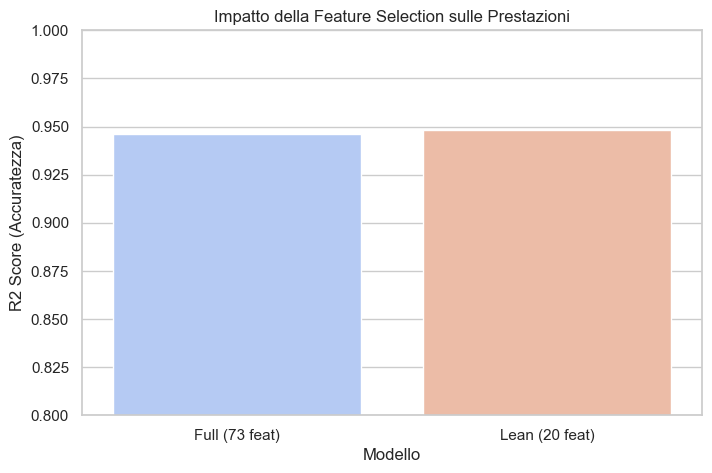

In [8]:
metrics_df = pd.DataFrame({
    'Modello': ['Full (73 feat)', 'Lean (20 feat)'],
    'R2 Score': [r2_full, r2_lean]
})

plt.figure(figsize=(8, 5))
sns.barplot(x='Modello', y='R2 Score', data=metrics_df, hue='Modello', palette='coolwarm', legend=False)
plt.ylim(0.8, 1.0) # Zoom sulla parte alta del grafico
plt.title('Impatto della Feature Selection sulle Prestazioni')
plt.ylabel('R2 Score (Accuratezza)')
plt.show()

In [9]:
# Selezioniamo solo le colonne utili + il target (CR)
cols_to_keep = top_20_features + ['cr']
df_lean = df[cols_to_keep]

# Salviamo il nuovo file
df_lean.to_csv("./data/monsters_lean.csv", index=False)
print("✅ Dataset ottimizzato salvato come 'monsters_lean.csv'")

✅ Dataset ottimizzato salvato come 'monsters_lean.csv'
